# Simulating nonnative cubic interactions on noisy quantum machines

### Implement gate $U(0.2,\pi/2,2)$

In [3]:
nshots = 8000
import warnings
warnings.simplefilter('ignore')

In [4]:
# importpackages
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.quantum_info import Statevector
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile

# import basic plot tools
from qiskit.visualization import plot_histogram

# IBMQ
from qiskit import IBMQ

In [5]:
# create quantum register (bundle of qubits)
n=2
qreg_q = QuantumRegister(n, 'q')

# we could add a classical register to record
#creg_c = ClassicalRegister(2, 'c')

# and then add both the quantum and classical to the circuit
#circuit = QuantumCircuit(qreg_q, creg_c)

circuit = QuantumCircuit(qreg_q)

# add individual gates
circuit.rz(pi, qreg_q[0])
circuit.rx(pi/2, qreg_q[1])
circuit.rx(pi/2, qreg_q[0])
circuit.rz(-0.955316618124509, qreg_q[0])
circuit.cz(qreg_q[0], qreg_q[1])
circuit.rx(pi/2, qreg_q[0])
circuit.rz(1.427466598294886, qreg_q[1])
circuit.rz(0.489897485566355, qreg_q[0])
circuit.rx(pi/2, qreg_q[1])
circuit.rx(-pi/2, qreg_q[0])
circuit.rz(0.39864643091, qreg_q[1])
circuit.rx(-pi/2, qreg_q[1])
circuit.cz(qreg_q[0], qreg_q[1])
circuit.rz(-2.186276035465, qreg_q[0])
circuit.rz(-1.714126055294, qreg_q[1])
circuit.rx(pi/2, qreg_q[0])
circuit.rx(-pi/2, qreg_q[1])
# draw
#circuit.draw('mpl')

## Create circuit
# we can convert the previous circuit to a custom gate
U_shi = circuit.to_gate()
U_shi.label = "$U(0.2,\pi/2,2)$"
# we can then add the new gate to a circuit many times
qc_shi = QuantumCircuit(2)
qc_shi.append(U_shi,[0,1])
#qc_shi.draw('mpl')

# Statevector simulation

In [6]:
# With Statevector we can impose an initial wavefunction
# without having to worry about state preparation
# which is usually non-trivial
psi0 = Statevector.from_label('00')
psi = psi0
tdim = 100
# occupation coefficients
alpha0 = np.zeros(tdim)
alpha1 = np.zeros(tdim)
alpha2 = np.zeros(tdim)
# evolve state in time
for t in range(tdim):
    # run circuit 1 time step
    alpha0[t] = np.abs(psi.data[0])**2
    alpha1[t] = np.abs(psi.data[2])**2
    alpha2[t] = np.abs(psi.data[1])**2
    psi = psi.evolve(qc_shi)
# instead of saving the amplitude^2
# we could have saved the entire wavefunction

# qasm_simulator

In [7]:
#qasm results
alpha0_qasm = np.zeros(tdim)
alpha1_qasm = np.zeros(tdim)
alpha2_qasm = np.zeros(tdim)

# use local simulator
shots_qasm = nshots
qasm_sim = Aer.get_backend('qasm_simulator')

for t in range(tdim):
    qreg_q = QuantumRegister(n, 'q')
    circuit2 = QuantumCircuit(qreg_q)
    for _ in range(t):
        circuit2.append(U_shi,[0,1])
    circuit2.measure_all()
    circuit2 = circuit2.decompose()
    #circuit2.draw('mpl')
    
    # run on qasm
    qobj = assemble(circuit2, qasm_sim)
    results = qasm_sim.run(qobj,shots=shots_qasm).result()
    answer = results.get_counts()
    # plot histogram
    #plot_histogram(answer)

    if '00' in answer:
        alpha0_qasm[t] = answer['00']/shots_qasm
    if '10' in answer:
        alpha1_qasm[t] = answer['10']/shots_qasm
    if '01' in answer:
        alpha2_qasm[t] = answer['01']/shots_qasm

We now prepare a list of circuits to be deployed to real quantum hardware

In [8]:
maxN = 74
qc_list = []
for N in range(maxN+1):
    
    # create quantum circuit
    qreg_q = QuantumRegister(n, 'q')
    qc = QuantumCircuit(qreg_q)
    
    # add gate
    for _ in range(0,N):
        qc.append(U_shi,[0,1])
    # add measure
    qc.measure_all()
    
    # append qc to list
    qc_list.append(qc)

In [10]:
# Load saved IBMQ accounts
# IBMQ.save_account('TOKEN')
IBMQ.load_account()
from qiskit.tools.monitor import job_monitor
#provider = IBMQ.get_provider(hub='ibm-q')
#backend = provider.get_backend('ibmq_santiago')

# Get the least busy backend device with greater than or equal to (n+1) qubits
#provider = IBMQ.get_provider(hub='ibm-q')
#backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits <= 5 and x.configuration().n_qubits >= 2 and
#                                   not x.configuration().simulator and x.status().operational==True))
#print("least busy backend: ", backend)

provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmq_manila')
print("backend: ", backend)

backend:  ibmq_manila


In [11]:
# Run with X shots
shots_ibm = nshots
t_qpe = transpile(qc_list, backend, optimization_level=3)
qobj = assemble(t_qpe, shots=shots_ibm)
job = backend.run(qobj)
job_monitor(job, interval=2)

Job Status: job has successfully run


In [12]:
ibm_res=job.result().get_counts()
#for i in ibm_res:
#    print(i)
# save results to array
alpha0_ibm = np.zeros(len(qc_list))
alpha1_ibm = np.zeros(len(qc_list))
alpha2_ibm = np.zeros(len(qc_list))

for t in range(len(qc_list)):
    answer = ibm_res[t]
    if '00' in answer:
        alpha0_ibm[t] = answer['00']/shots_ibm
    if '10' in answer:
        alpha1_ibm[t] = answer['10']/shots_ibm
    if '01' in answer:
        alpha2_ibm[t] = answer['01']/shots_ibm

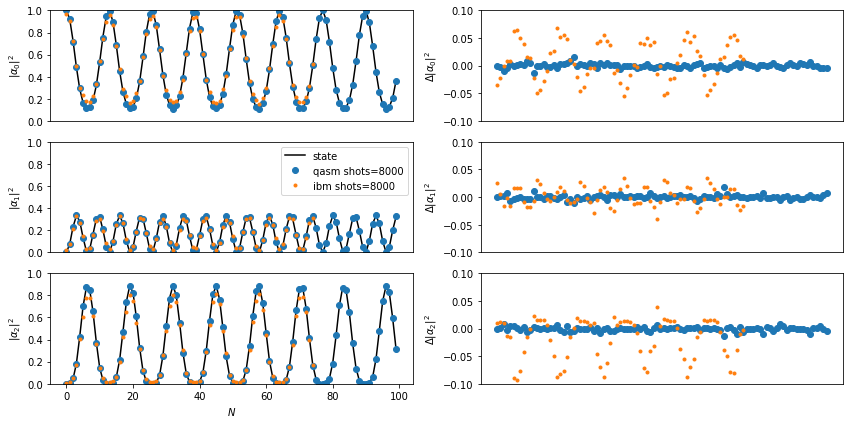

In [14]:
# plot reproducing FIG2

fig, axes= plt.subplots(nrows=3, ncols=2,figsize=(12,6))

plt.subplot(321)
plt.plot(alpha0,'k')
plt.plot(alpha0_qasm,'o')
plt.plot(alpha0_ibm,'.')
plt.ylim([0,1])
plt.xticks([])
plt.ylabel(r'$|\alpha_0|^2$')
plt.subplot(323)
plt.plot(alpha1,'k',label='state')
plt.plot(alpha1_qasm,'o',label=r'qasm shots={}'.format(nshots))
plt.plot(alpha1_ibm,'.',label=r'ibm shots={}'.format(nshots))
plt.ylim([0,1])
plt.xticks([])
plt.legend(loc='best')
plt.ylabel(r'$|\alpha_1|^2$')
plt.subplot(325)
plt.plot(alpha2,'k')
plt.plot(alpha2_qasm,'o')
plt.plot(alpha2_ibm,'.')
plt.ylim([0,1])
plt.xlabel(r'$N$')
plt.ylabel(r'$|\alpha_2|^2$')

# error
plt.subplot(322)
plt.plot(alpha0_qasm-alpha0,'o')
plt.plot(alpha0_ibm-alpha0[:75],'.')
plt.xticks([])
plt.ylabel(r'$\Delta |\alpha_0|^2$')
plt.ylim([-0.1,+0.1])
plt.subplot(324)
plt.plot(alpha1_qasm-alpha1,'o')
plt.plot(alpha1_ibm-alpha1[:75],'.')
plt.xticks([])
plt.ylabel(r'$\Delta |\alpha_1|^2$')
plt.ylim([-0.1,+0.1])
plt.subplot(326)
plt.plot(alpha2_qasm-alpha2,'o')
plt.plot(alpha2_ibm-alpha2[:75],'.')
plt.xticks([])
plt.ylabel(r'$\Delta |\alpha_2|^2$')
plt.ylim([-0.1,+0.1])

plt.tight_layout()
plt.savefig('shots_{}.pdf'.format(nshots))
plt.show()